In [66]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import tensorflow_addons as tfa  # thư viện cho Attention
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from keras.layers import LSTM, Dense, Input, Attention,concatenate
from keras.models import Model
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [67]:

data = pd.read_csv(r'C:\Users\57\Desktop\DOANTOTNGHIEP\Data\KichBan1_2\train_data2.csv') 
data.set_index('Ngay', inplace=True)
print(data.head(5))

            mucNuocHN  nuocVeHoaBinh  chayMayHoaBinh  nuocVeTuyenQuang  \
Ngay                                                                     
01/01/2008        120        498.815         259.499               0.0   
02/01/2008        117        470.866         518.755               0.0   
03/01/2008        139        423.816         615.242               0.0   
04/01/2008        166        496.882         902.982               0.0   
05/01/2008        179        501.232        1072.970               0.0   

            chayMayTuyenQuan  nuocVeThacBa  chayMayThacBa  
Ngay                                                       
01/01/2008               0.0        23.230         90.200  
02/01/2008               0.0        26.239        213.791  
03/01/2008               0.0        24.000        175.000  
04/01/2008               0.0        11.000        164.000  
05/01/2008               0.0        24.000        177.000  


In [68]:
# Chuẩn hóa dữ liệu để đưa về khoảng [0, 1] để dễ xử lý khi đưa vào mô hình
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

In [69]:
def create_sequences(data, seq_length):
    sequences = []
    targets = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i + seq_length])
        targets.append(data[i + seq_length, 0])  
    return np.array(sequences), np.array(targets)

In [70]:
sequence_length = 2 # Sử dụng 30 ngày để dự đoán
X, y = create_sequences(data_scaled, sequence_length)
X_train_decoded = []

# Loop through each sequence in X_train
for i in range(X.shape[0]):
    # Reshape each sequence to 2D, apply inverse transform, and add to the decoded list
    original_values = scaler.inverse_transform(X[i])
    X_train_decoded.append(original_values)
X_train_decoded = np.array(X_train_decoded)
print(X_train_decoded)

[[[120.    498.815 259.499 ...   0.     23.23   90.2  ]
  [117.    470.866 518.755 ...   0.     26.239 213.791]]

 [[117.    470.866 518.755 ...   0.     26.239 213.791]
  [139.    423.816 615.242 ...   0.     24.    175.   ]]

 [[139.    423.816 615.242 ...   0.     24.    175.   ]
  [166.    496.882 902.982 ...   0.     11.    164.   ]]

 ...

 [[111.    482.    355.    ... 118.251  95.65   85.65 ]
  [108.    442.    386.    ...  58.377 119.589   0.   ]]

 [[108.    442.    386.    ...  58.377 119.589   0.   ]
  [ 84.    268.    474.    ...  94.274  95.65   85.65 ]]

 [[ 84.    268.    474.    ...  94.274  95.65   85.65 ]
  [ 80.    543.    345.    ... 115.226 113.294  75.867]]]


In [71]:
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))

In [72]:
input_layer = Input(shape=(X.shape[1], X.shape[2]))
lstm_out = LSTM(64, return_sequences=True)(input_layer)

In [73]:
output_layer = Dense(1)(lstm_out)

In [74]:
model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 2, 7)]            0         
                                                                 
 lstm_3 (LSTM)               (None, 2, 64)             18432     
                                                                 
 dense_3 (Dense)             (None, 2, 1)              65        
                                                                 
Total params: 18497 (72.25 KB)
Trainable params: 18497 (72.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [75]:
# 3. Huấn luyện mô hình
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/50
64/64 [==============================] - 6s 19ms/step - loss: 0.0401 - val_loss: 0.0116
Epoch 2/50
64/64 [==============================] - 0s 7ms/step - loss: 0.0299 - val_loss: 0.0140
Epoch 3/50
64/64 [==============================] - 1s 11ms/step - loss: 0.0290 - val_loss: 0.0146
Epoch 4/50
64/64 [==============================] - 1s 12ms/step - loss: 0.0290 - val_loss: 0.0149
Epoch 5/50
64/64 [==============================] - 1s 8ms/step - loss: 0.0288 - val_loss: 0.0144
Epoch 6/50
64/64 [==============================] - 1s 12ms/step - loss: 0.0288 - val_loss: 0.0148
Epoch 7/50
64/64 [==============================] - 1s 13ms/step - loss: 0.0287 - val_loss: 0.0151
Epoch 8/50
64/64 [==============================] - 1s 8ms/step - loss: 0.0287 - val_loss: 0.0149
Epoch 9/50
64/64 [==============================] - 1s 12ms/step - loss: 0.0288 - val_loss: 0.0151
Epoch 10/50
64/64 [==============================] - 1s 11ms/step - loss: 0.0287 - val_loss: 0.0150
Epoch 11/50


In [76]:
def nse(y_true, y_pred):
    """Tính toán NSE (Nash-Sutcliffe Efficiency)"""
    # Đảm bảo y_true và y_pred là mảng numpy
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Tính toán giá trị NSE
    return 1 - np.sum((y_true - y_pred) ** 2) / np.sum((y_true - np.mean(y_true)) ** 2)

In [77]:
y_pred = model.predict(X_test)
# Chuyển đổi kích thước y_pred để phù hợp với y_test
y_pred = y_pred.reshape(y_pred.shape[0], -1)  # Biến đổi thành mảng 2 chiều
y_pred = y_pred[:, 0]  # Lấy cột đầu tiên nếu y_pred có nhiều cột

y_test = y_test.flatten()  
r2 = r2_score(y_test, y_pred)
print("R² (R-squared):", r2)

#Tính MAE
mae = mean_absolute_error(y_test, y_pred)
print("MAE (Mean Absolute Error):", mae)

# Tính RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE (Root Mean Square Error):", rmse)

# Tính NSE
nse = nse(y_test, y_pred)
print("NSE (Nash-Sutcliffe Efficiency):", nse)

16/16 [==============================] - 1s 5ms/step
R² (R-squared): -0.05784961703448688
MAE (Mean Absolute Error): 0.10608723890375991
RMSE (Root Mean Square Error): 0.12550866782348685
NSE (Nash-Sutcliffe Efficiency): -0.05784961703448688


In [78]:
# 5. Vẽ đồ thị dự báo so sánh với thực tế cho từng mực nước
new_data = pd.read_csv(r'C:\Users\57\Desktop\DOANTOTNGHIEP\Data\KichBan1_2\test_data2_1.csv') 
new_data['Ngay'] = pd.to_datetime(new_data['Ngay'], format='%d/%m/%Y')
new_data.set_index('Ngay', inplace=True)
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(new_data)

In [79]:
data_test_scaled = scaler.transform(new_data)

# Tạo các mẫu test từ dữ liệu test
X_test_new, y_test_new = create_sequences(data_test_scaled,sequence_length)

# Định dạng lại dữ liệu test để phù hợp với mô hình
X_test_new = np.reshape(X_test_new, (X_test_new.shape[0], X_test_new.shape[1], X_test_new.shape[2]))

In [80]:
# Dự đoán trên dữ liệu đầu vào
predictions_new = model.predict(X_test_new)

# Đưa dự đoán về dạng 2D
predictions_new_reshaped = predictions_new.reshape(-1, predictions_new.shape[-1])  # Chuyển thành 2D

# Số cột từ scaler
num_columns = data_scaled.shape[1]

# Tạo mảng đủ cột để kết hợp
zeros_to_add = np.zeros((predictions_new_reshaped.shape[0], num_columns - predictions_new_reshaped.shape[1]))

# Chuyển đổi giá trị dự đoán về kích thước ban đầu
predictions_new_original = scaler.inverse_transform(
    np.concatenate((predictions_new_reshaped, zeros_to_add), axis=1)
)[:, 0]  # Lấy cột đầu tiên cho mực nước


# Giả sử y_test_new có kích thước (num_samples, 1)
y_test_new_original = y_test_new.reshape(-1, 1)  # Chuyển thành 2D nếu cần

# Tạo mảng đủ cột để kết hợp cho y_test_new
zeros_to_add_y_test = np.zeros((y_test_new_original.shape[0], num_columns - 1))  # Số cột - 1 vì y_test_new chỉ có 1 cột

# Chuyển đổi giá trị thực tế về kích thước ban đầu
y_test_new_original = scaler.inverse_transform(
    np.concatenate((y_test_new_original, zeros_to_add_y_test), axis=1)
)[:, 0] 


23/23 [==============================] - 0s 6ms/step


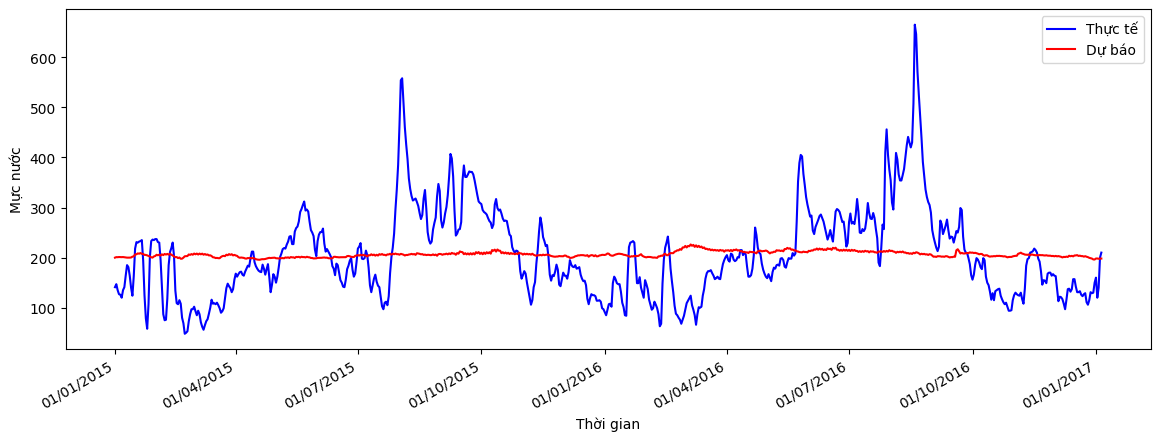

In [81]:
# Đảm bảo các mảng có cùng kích thước
import matplotlib.dates as mdates

min_length = min(len(new_data.index), len(y_test_new_original), len(predictions_new_original))

# Cắt ngắn mảng theo độ dài nhỏ nhất
dates = new_data.index[:min_length]
y_test_new_original = y_test_new_original[:min_length]
predictions_new_original = predictions_new_original[:min_length]

# Vẽ biểu đồ
plt.figure(figsize=(14, 5))
plt.plot(dates, y_test_new_original, label='Thực tế', color='blue')
plt.plot(dates, predictions_new_original, label='Dự báo', color='red')
plt.xlabel('Thời gian')
plt.ylabel('Mực nước')

# Định dạng ngày tháng
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d/%m/%Y'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.legend()
plt.gcf().autofmt_xdate()
plt.show()
